In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

In [2]:
current_dir = os.getcwd()

charts_folder = "charts"
data_folder = "data"
logs_folder = "logs"

if not os.path.exists(data_folder):
    os.makedirs(data_folder)

if not os.path.exists(logs_folder):
    os.makedirs(logs_folder)

if not os.path.exists(charts_folder):
    os.makedirs(charts_folder)

one_milion_forecasters = int(1e6)
strong_scaling_forecasters = int(1e5)
weak_scaling_forecasters = int(1e5)

one_milion_nodes = 10
strong_scaling_nodes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Number of nodes to test
weak_scaling_nodes   = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Number of nodes to test

GENERATE_DATA = False


In [3]:
def submit_job(num_nodes, num_forecasters, job_name):
    num_tasks_per_node = 128

    if num_tasks_per_node > 128:
        print("The number of tasks per node should be less than or equal to 128")
        exit(1)

    if not os.path.exists(f"{data_folder}/{job_name}"):
        os.makedirs(f"{data_folder}/{job_name}")

    if not os.path.exists(f"{logs_folder}/{job_name}"):
        os.makedirs(f"{logs_folder}/{job_name}")

    with open('launch.sh', 'r') as file:
        launch_script = file.read()

    launch_script = launch_script.format(
        num_nodes=num_nodes,
        num_tasks_per_node=num_tasks_per_node,
        current_dir=current_dir,
        world_size=num_nodes*num_tasks_per_node,
        num_forecasters=num_forecasters,
        data_folder=f"{data_folder}/{job_name}",
        logs_folder=f"{logs_folder}/{job_name}"
    )

    script_filename = f"{logs_folder}/{job_name}/launch.sh"
    with open(script_filename, "w") as script_file:
        script_file.write(launch_script)

    os.system(f"sbatch {script_filename}")

In [4]:
def one_milion_test():
    job_name = f"num_forecasters_{one_milion_forecasters}_num_nodes_{one_milion_nodes}_one_milion_test"

    submit_job(one_milion_nodes, one_milion_forecasters, job_name)

    return job_name

In [5]:
def strong_scaling():
    job_names = [ f"num_forecasters_{strong_scaling_forecasters}_num_nodes_{num_nodes}_strong_scaling" for num_nodes in strong_scaling_nodes ]

    # Submit jobs for each test configuration
    for i, num_nodes in enumerate(strong_scaling_nodes):
        submit_job(num_nodes, strong_scaling_forecasters, job_names[i])

    return job_names

In [6]:
def weak_scaling():
    job_names = [ f"num_forecasters_{weak_scaling_forecasters*num_nodes}_num_nodes_{num_nodes}_weak_scaling" for num_nodes in weak_scaling_nodes ]

    # Submit jobs for each test configuration
    for i, num_nodes in enumerate(weak_scaling_nodes):
        submit_job(num_nodes, weak_scaling_forecasters*num_nodes, job_names[i])

    return job_names

In [7]:
all_jobs_to_wait = []

if GENERATE_DATA:
    all_jobs_to_wait.append(one_milion_test())
    all_jobs_to_wait.extend(strong_scaling())
    all_jobs_to_wait.extend(weak_scaling())

    print("Waiting for jobs to finish...")
    print(all_jobs_to_wait)

In [8]:
for job_name in tqdm(all_jobs_to_wait):
    while not os.path.exists(f"{data_folder}/{job_name}/timings.txt"):
        time.sleep(10)  # Poll every 10 seconds

0it [00:00, ?it/s]


(1000000, 5, 2)
(1000000, 2, 6)
(1000000, 1)


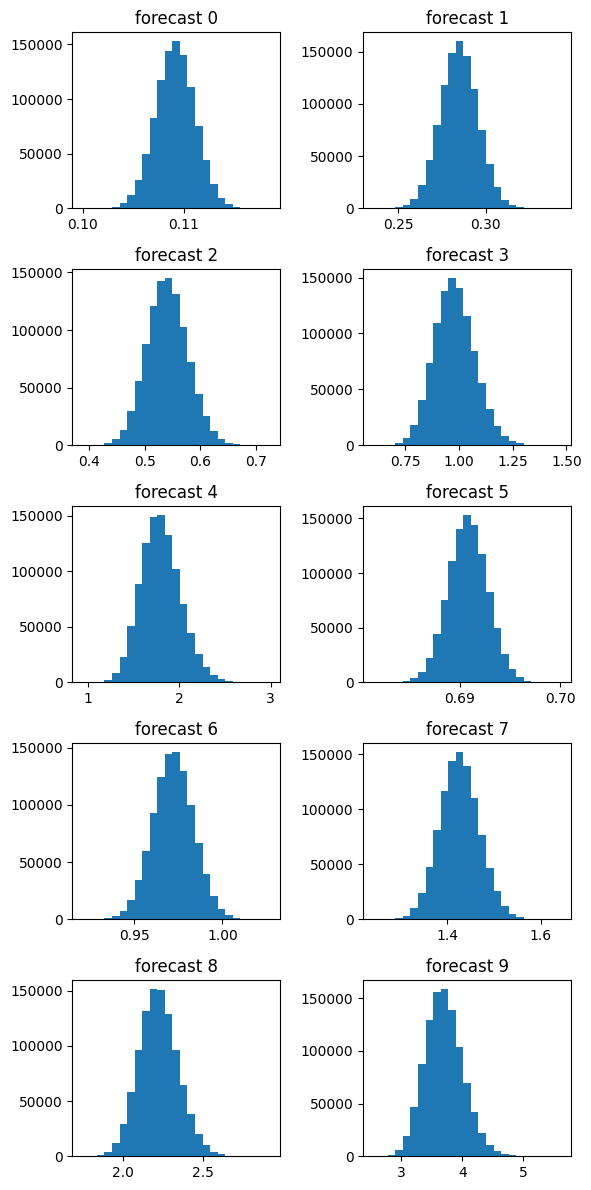

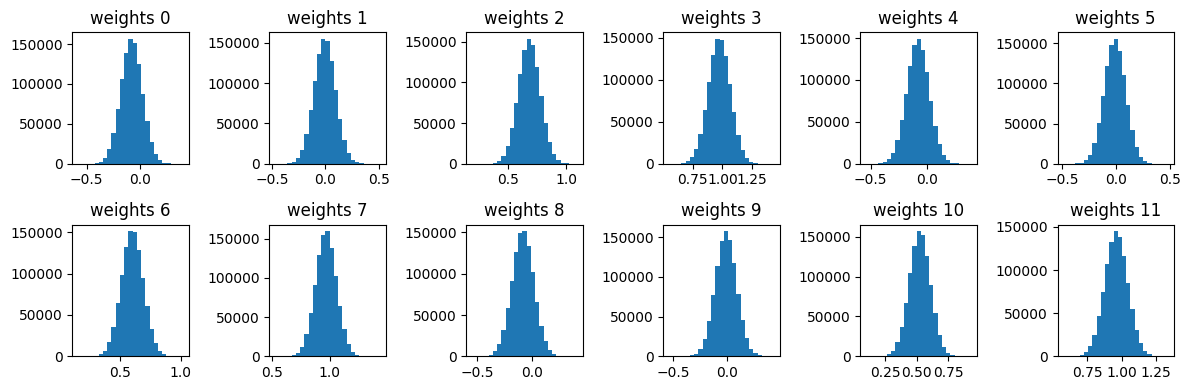

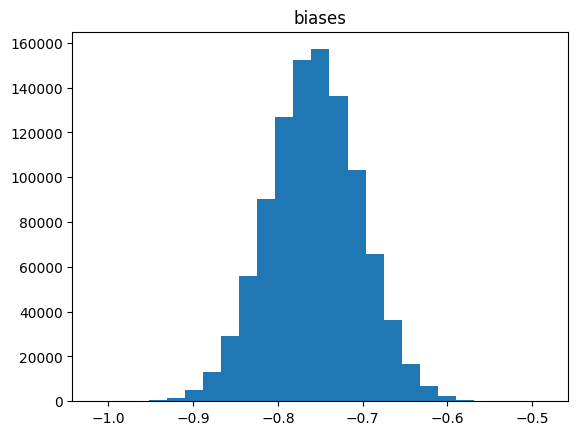

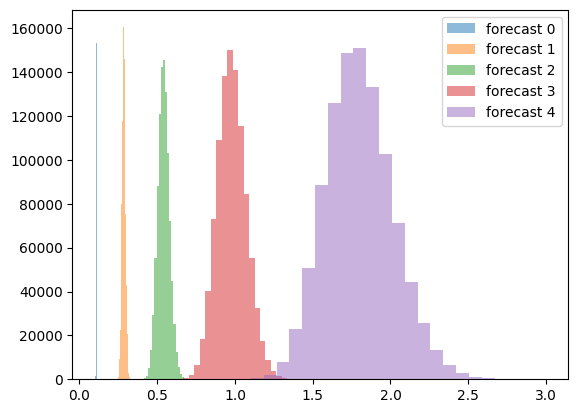

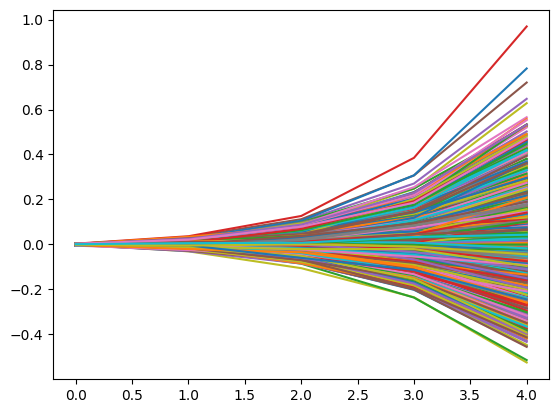

In [9]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

one_milion_folder = f"data/num_forecasters_{one_milion_forecasters}_num_nodes_{one_milion_nodes}_one_milion_test"

forecast = np.load(f"{one_milion_folder}/forecasting.npy")
weights  = np.load(f"{one_milion_folder}/weights.npy")
biases   = np.load(f"{one_milion_folder}/biases.npy")

print(forecast.shape)
print(weights.shape)
print(biases.shape)

n_bins = 25

## FORECASTER PLOT
variable = forecast
fig, axs = plt.subplots(5, 2, figsize=(6, 12))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Plot histograms in each subplot
for z in range(variable.shape[2]):
    for y in range(variable.shape[1]):
        f_list = []
        for x in range(variable.shape[0]):
            f_list.append(variable[x][y][z])
        axs[z*variable.shape[1]+y].hist(f_list, bins=n_bins)
        axs[z*variable.shape[1]+y].set_title(f'forecast {z*variable.shape[1]+y}')
f_list = []

plt.tight_layout()
plt.show()

## WEIGHTS PLOT
variable = weights
fig, axs = plt.subplots(variable.shape[1], variable.shape[2], figsize=(12, 4))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Plot histograms in each subplot
for z in range(variable.shape[2]):
    for y in range(variable.shape[1]):
        f_list = []
        for x in range(variable.shape[0]):
            f_list.append(variable[x][y][z])
        axs[z*variable.shape[1]+y].hist(f_list, bins=n_bins)
        axs[z*variable.shape[1]+y].set_title(f'weights {z*variable.shape[1]+y}')
f_list = []

plt.tight_layout()
plt.show()

## BIASES PLOT
variable = biases

# Plot histograms of f_list
for x in range(variable.shape[0]):
    f_list.append(variable[x][0])

plt.hist(f_list, bins=n_bins)
#Put a name
plt.title('biases')


forecasted_values_tot = []
## PLOT OF THE FORECASTED VALUES
for j in range(forecast.shape[1]):
    forecasted = []
    for i in range(forecast.shape[0]):
        forecasted.append(forecast[i][j][0])
    forecasted_values_tot.append(forecasted)

# New figure for a new plot
plt.figure()
# Plot the hist forecasted values in the same graph with different colours
for i in range(5):
    plt.hist(forecasted_values_tot[i], bins=n_bins, alpha=0.5, label=f'forecast {i}')

plt.legend()
forecasts_mean = np.mean(forecast, axis=0)

# normalize by subtracting the mean
forecast_normalized = forecast - forecasts_mean

forecasted_values_tot = []
## PLOT OF THE FORECASTED VALUES
for i in range(1000):
    forecasted = []
    
    for j in range(5):
        forecasted.append(forecast_normalized[i][j][0])
    
    forecasted_values_tot.append(forecasted)

plt.figure()

# plot the lines
for i in range(1000):
    plt.plot(forecasted_values_tot[i], label=f'forecast {i}')


Strong scalability test:


In [10]:
execution_times_strong_scaling = []

# Submit jobs for each test configuration
for num_nodes in strong_scaling_nodes:
    execution_time_file = f"{data_folder}/num_forecasters_{strong_scaling_forecasters}_num_nodes_{num_nodes}_strong_scaling/timings.txt"

    with open(execution_time_file, "r") as f:
        execution_time = float(f.read())
    execution_times_strong_scaling.append(execution_time)
    print(f"Execution time for {num_nodes} nodes: {execution_time} seconds")


Execution time for 1 nodes: 103.10832643508911 seconds
Execution time for 2 nodes: 77.11499261856079 seconds
Execution time for 3 nodes: 71.98234558105469 seconds
Execution time for 4 nodes: 60.789494037628174 seconds
Execution time for 5 nodes: 62.60256218910217 seconds
Execution time for 6 nodes: 58.85095477104187 seconds
Execution time for 7 nodes: 58.12559509277344 seconds
Execution time for 8 nodes: 58.461100578308105 seconds
Execution time for 9 nodes: 56.91094207763672 seconds
Execution time for 10 nodes: 55.99758553504944 seconds


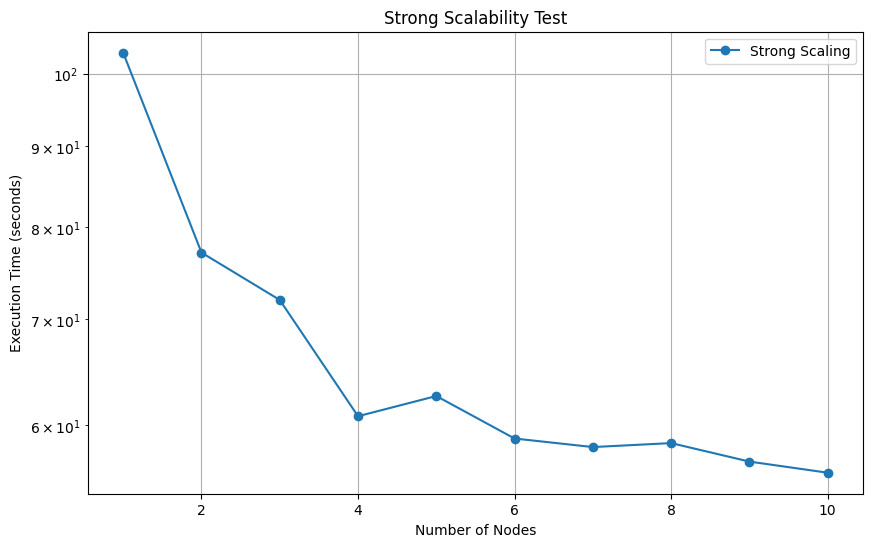

In [11]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.yscale('log')
plt.plot(strong_scaling_nodes, execution_times_strong_scaling, label='Strong Scaling', marker='o')
plt.xlabel('Number of Nodes')
plt.ylabel('Execution Time (seconds)')
plt.title('Strong Scalability Test')
plt.grid(True)
plt.legend()
plt.savefig(f"{charts_folder}/scalability_plot.png") 
plt.show()

Weak scalability test:


In [12]:
execution_times_weak_scaling = []

# Submit jobs for each test configuration
for num_nodes in weak_scaling_nodes:
    execution_time_file = f"{data_folder}/num_forecasters_{weak_scaling_forecasters*num_nodes}_num_nodes_{num_nodes}_weak_scaling/timings.txt"

    with open(execution_time_file, "r") as f:
        execution_time = float(f.read())
    execution_times_weak_scaling.append(execution_time)

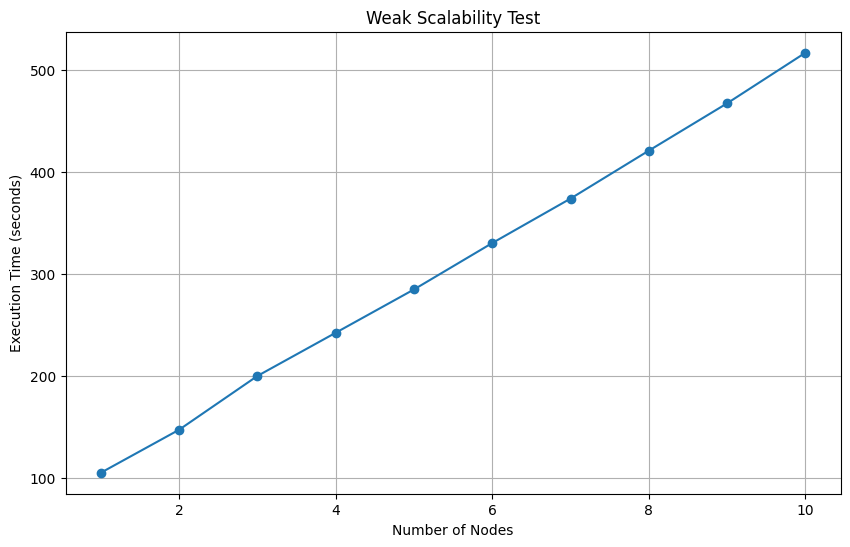

In [13]:

# Plot the weak scalability results
plt.figure(figsize=(10, 6))
plt.plot(weak_scaling_nodes, execution_times_weak_scaling, label='Weak Scaling', marker='o')
plt.xlabel("Number of Nodes")
plt.ylabel("Execution Time (seconds)")
plt.title("Weak Scalability Test")
plt.grid(True)
plt.savefig(f"{charts_folder}/weak_scalability.png")
plt.show()